In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 300)

In [2]:
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from itertools import product
from datetime import datetime
from scipy import stats
from sklearn.metrics import mean_squared_error

In [ ]:
# from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.tsa.stattools import adfuller

# import statsmodels.formula.api as smf
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('./data/btc_daily_all.csv', parse_dates=['Date'], \
                 index_col='Date', date_parser=dateparse)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-07-17,0.04951,0.04951,0.04951,0.04951,0.04951,0
2010-07-18,0.04951,0.08585,0.05941,0.08584,0.08584,5
2010-07-19,0.08584,0.09307,0.07723,0.08080,0.08080,49
2010-07-20,0.08080,0.08181,0.07426,0.07474,0.07474,20
2010-07-21,0.07474,0.07921,0.06634,0.07921,0.07921,42


In [4]:
df = df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
df.shape

(2975, 1)

In [5]:
df = df.loc[df.index > '2011-12-31']
df.columns = ['Price']
df.head()

,Price
Date,
2012-01-01,5.27
2012-01-02,5.22
2012-01-03,4.88
2012-01-04,5.57
2012-01-05,6.95


In [6]:
print(df.describe())
print('===================')
print(df.dtypes)

              Price
count   2442.000000
mean    1701.009751
std     3143.328980
min        4.220000
25%      135.000000
50%      423.894989
75%      957.307511
max    19345.490234
Price    float64
dtype: object


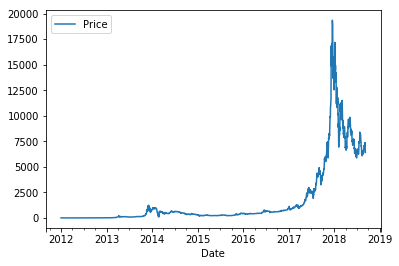

In [7]:
df.plot()

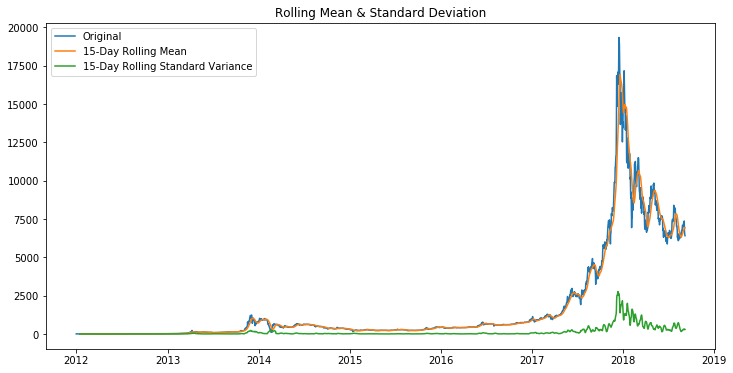

In [8]:
plt.figure(figsize=(12,6))
rolmean = df['Price'].rolling(window=15).mean()
rolvar = df['Price'].rolling(window=15).std()
plt.plot(df['Price'], label='Original')
plt.plot(rolmean, label='15-Day Rolling Mean')
plt.plot(rolvar, label='15-Day Rolling Standard Variance')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [9]:
df_month = df.resample('M').mean()
df_qrt   = df.resample('Q-DEC').mean()
df_year  = df.resample('A-DEC').mean()

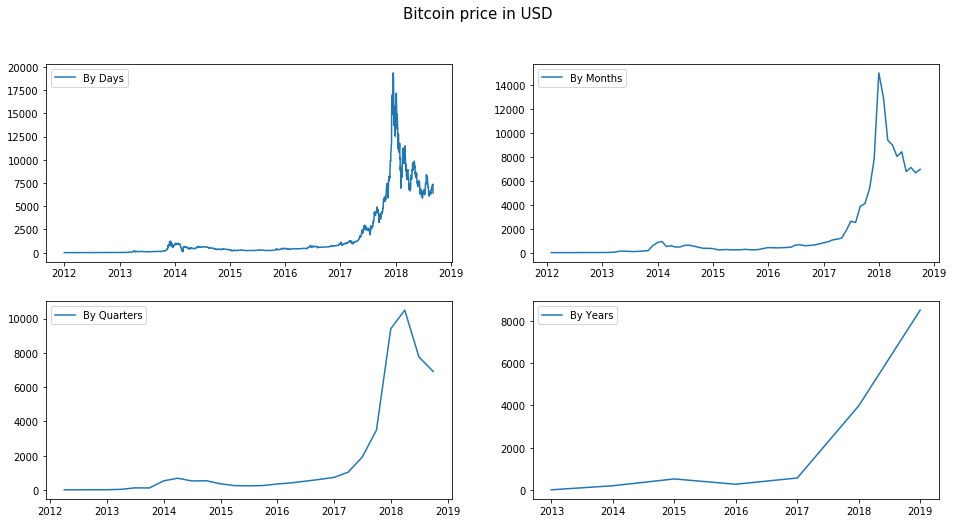

In [10]:
fig = plt.figure(figsize=[16, 8])
plt.suptitle('Bitcoin price in USD', fontsize=15)
plt.subplot(221)
plt.plot(df.Price, '-', label='By Days')
plt.legend()
plt.subplot(222)
plt.plot(df_month.Price, '-', label='By Months')
plt.legend()
plt.subplot(223)
plt.plot(df_qrt.Price, '-', label='By Quarters')
plt.legend()
plt.subplot(224)
plt.plot(df_year.Price, '-', label='By Years')
plt.legend()
# plt.tight_layout()
plt.show()

In [11]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    from statsmodels.tsa.stattools import adfuller
    print('Results of Dickey-Fuller Test:')
    print ("==============================")
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [12]:
test_stationarity(df['Price'])

Results of Dickey-Fuller Test:
Test Statistic                   -1.643327
p-value                           0.460523
#lags Used                       27.000000
Number of Observations Used    2414.000000
Critical Value (1%)              -3.433062
Critical Value (5%)              -2.862738
Critical Value (10%)             -2.567408
dtype: float64


In [13]:
test_stationarity(df_month['Price'])

Results of Dickey-Fuller Test:
Test Statistic                 -1.386962
p-value                         0.588510
#lags Used                      1.000000
Number of Observations Used    79.000000
Critical Value (1%)            -3.515977
Critical Value (5%)            -2.898886
Critical Value (10%)           -2.586694
dtype: float64


Decomposition of time series: Monthly


<Figure size 2160x864 with 0 Axes>

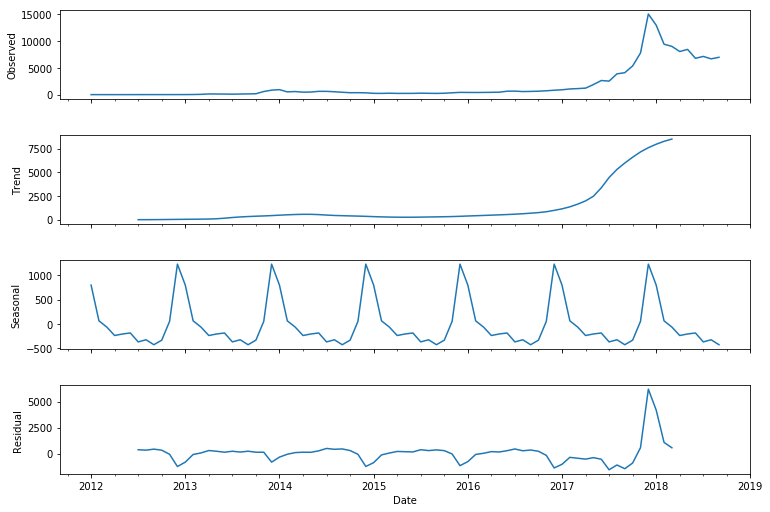

In [14]:
plt.figure(figsize=(30,12))
decomposition = sm.tsa.seasonal_decompose(df_month['Price'])
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
print('Decomposition of time series: Monthly')
plt.show()

In [15]:
log_dfm = df_month.copy()
log_dfm.columns = ['Log.Price']
log_dfm['Log.Price'] = np.log(log_dfm['Log.Price'])
log_dfm.head()

,Log.Price
Date,
2012-01-31,1.810982
2012-02-29,1.630592
2012-03-31,1.589630
2012-04-30,1.607102
2012-05-31,1.623850


In [16]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(log_dfm['Log.Price'])[1])
test_stationarity(log_dfm['Log.Price'])

Dickey–Fuller test: p=0.283306
Results of Dickey-Fuller Test:
Test Statistic                 -2.007473
p-value                         0.283306
#lags Used                      7.000000
Number of Observations Used    73.000000
Critical Value (1%)            -3.523284
Critical Value (5%)            -2.902031
Critical Value (10%)           -2.588371
dtype: float64


Decomposition of time series: Monthly Log


<Figure size 2160x864 with 0 Axes>

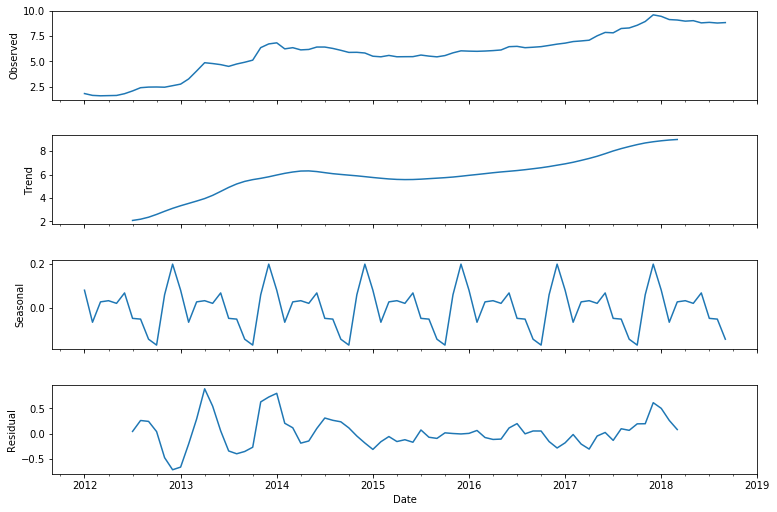

In [17]:
plt.figure(figsize=(30,12))
decomposition = sm.tsa.seasonal_decompose(log_dfm['Log.Price'])
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
print('Decomposition of time series: Monthly Log')
plt.show()

In [18]:
ret_log_dfm = log_dfm.copy()
ret_log_dfm.columns = ['Ret.Log.Price']
ret_log_dfm['Ret.Log.Price'] = ret_log_dfm['Ret.Log.Price'].diff()
ret_log_dfm = ret_log_dfm.iloc[1:]
ret_log_dfm.head(2)

,Ret.Log.Price
Date,
2012-02-29,-0.180390
2012-03-31,-0.040962


In [19]:
test_stationarity(ret_log_dfm['Ret.Log.Price'])

Results of Dickey-Fuller Test:
Test Statistic                 -1.816838
p-value                         0.372135
#lags Used                      6.000000
Number of Observations Used    73.000000
Critical Value (1%)            -3.523284
Critical Value (5%)            -2.902031
Critical Value (10%)           -2.588371
dtype: float64


Decomposition of time series: Monthly Log Return


<Figure size 2160x864 with 0 Axes>

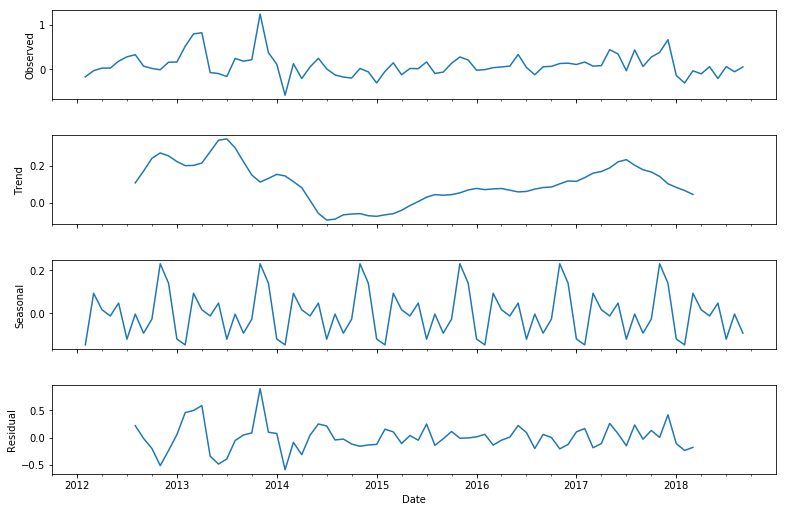

In [20]:
plt.figure(figsize=(30,12))
decomposition = sm.tsa.seasonal_decompose(ret_log_dfm['Ret.Log.Price'])
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
print('Decomposition of time series: Monthly Log Return')
plt.show()

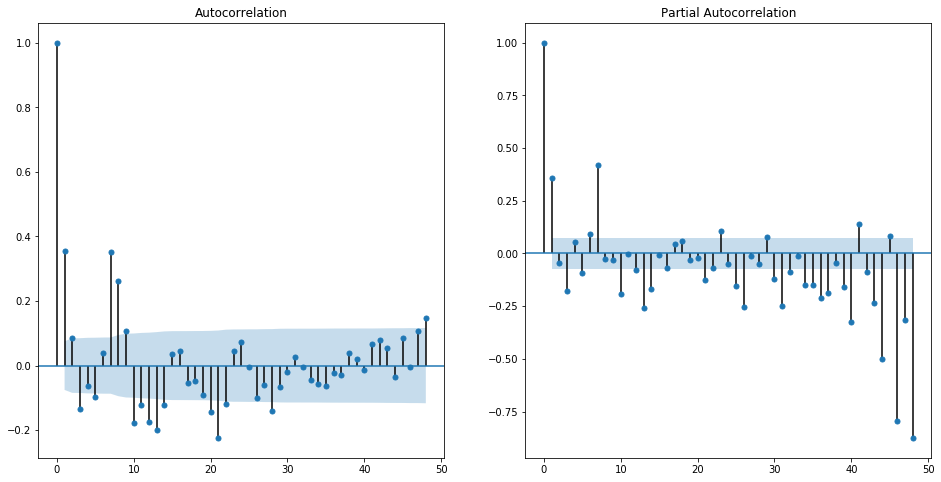

In [21]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(16)
fig.set_figheight(8)
smt.graphics.plot_acf(ret_log_dfm['Ret.Log.Price'], lags=48, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(ret_log_dfm['Ret.Log.Price'], lags=48, ax=axes[1], alpha=0.5)
# plt.tight_layout()
plt.show()

In [22]:
Qs = range(0,3)
qs = range(0,3)
Ps = range(0,3)
ps = range(0,3)
Ds = range(0,2)
ds = range(0,2)
parameters = product(ps, ds, qs, Ps, Ds, Qs)
parameters_list = list(parameters)
print(len(parameters_list))
parameters_list[:10]

324


[(0, 0, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 1),
 (0, 0, 0, 0, 0, 2),
 (0, 0, 0, 0, 1, 0),
 (0, 0, 0, 0, 1, 1),
 (0, 0, 0, 0, 1, 2),
 (0, 0, 0, 1, 0, 0),
 (0, 0, 0, 1, 0, 1),
 (0, 0, 0, 1, 0, 2),
 (0, 0, 0, 1, 1, 0)]

In [23]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(log_dfm['Log.Price'], order=(param[0], param[1], param[2]), \
                                        seasonal_order=(param[3], param[4], param[5], 12)).fit()
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

wrong parameters: (0, 0, 0, 0, 0, 1)
wrong parameters: (0, 0, 0, 0, 0, 2)
wrong parameters: (0, 0, 0, 0, 1, 1)
wrong parameters: (0, 0, 0, 0, 1, 2)
wrong parameters: (0, 0, 0, 1, 0, 0)
wrong parameters: (0, 0, 0, 1, 0, 1)
wrong parameters: (0, 0, 0, 1, 0, 2)
wrong parameters: (0, 0, 0, 1, 1, 2)
wrong parameters: (0, 0, 0, 2, 0, 0)
wrong parameters: (0, 0, 0, 2, 0, 1)
wrong parameters: (0, 0, 0, 2, 0, 2)
wrong parameters: (0, 0, 0, 2, 1, 1)
wrong parameters: (0, 0, 0, 2, 1, 2)
wrong parameters: (0, 0, 1, 0, 0, 0)
wrong parameters: (0, 0, 1, 0, 0, 1)
wrong parameters: (0, 0, 1, 0, 0, 2)
wrong parameters: (0, 0, 1, 0, 1, 0)
wrong parameters: (0, 0, 1, 0, 1, 1)
wrong parameters: (0, 0, 1, 0, 1, 2)
wrong parameters: (0, 0, 1, 1, 0, 0)
wrong parameters: (0, 0, 1, 1, 0, 1)
wrong parameters: (0, 0, 1, 1, 0, 2)
wrong parameters: (0, 0, 1, 1, 1, 0)
wrong parameters: (0, 0, 1, 1, 1, 1)
wrong parameters: (0, 0, 1, 1, 1, 2)
wrong parameters: (0, 0, 1, 2, 0, 0)
wrong parameters: (0, 0, 1, 2, 0, 1)
w

In [24]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

             parameters        aic
53   (1, 1, 0, 0, 0, 0)  10.218534
77   (1, 1, 2, 0, 0, 0)  10.335794
29   (0, 1, 2, 0, 0, 0)  10.495316
113  (2, 1, 2, 0, 0, 0)  12.044862
57   (1, 1, 0, 1, 0, 0)  12.114305
                           Statespace Model Results                           
Dep. Variable:              Log.Price   No. Observations:                   81
Model:               SARIMAX(1, 1, 0)   Log Likelihood                  -3.109
Date:                Mon, 17 Sep 2018   AIC                             10.219
Time:                        16:43:45   BIC                             14.983
Sample:                    01-31-2012   HQIC                            12.129
                         - 09-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------


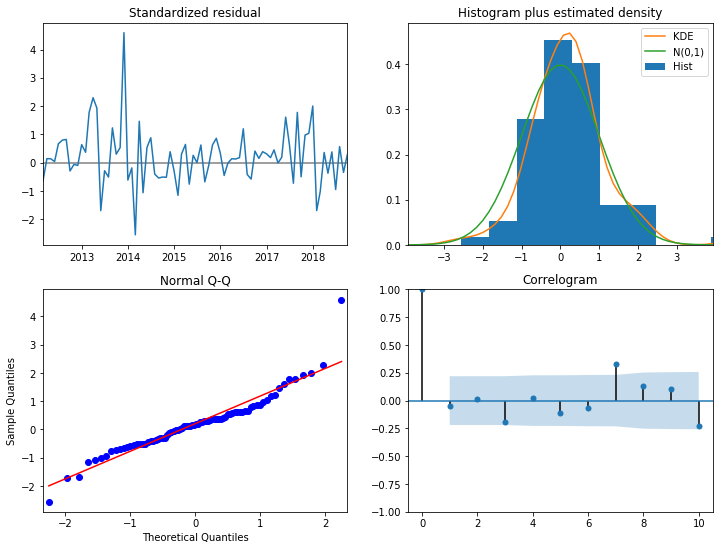

In [25]:
best_model.plot_diagnostics(figsize=(10,6))
plt.show()

Dickey–Fuller test:: p=0.019358


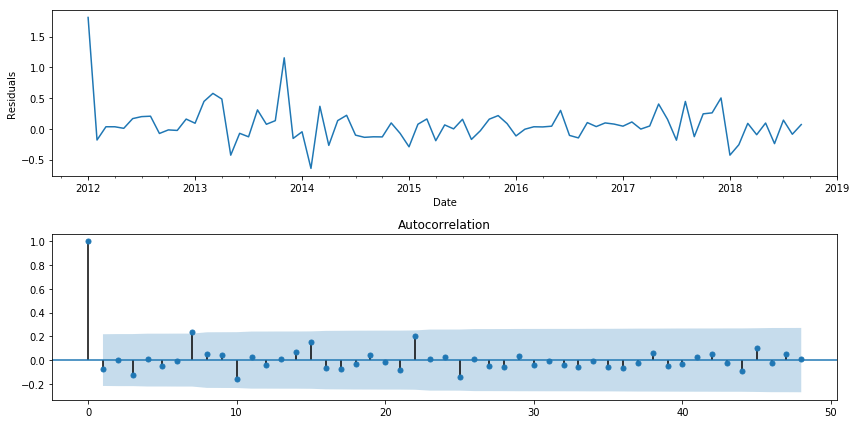

In [54]:
plt.figure(figsize=(12,6))
plt.subplot(211)
best_model.resid[0:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid, lags=48, ax=ax)
print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])
plt.tight_layout()
plt.show()

In [56]:
print(df_month.head(2))
print(df_month.tail(2))
df_month.shape

               Price
Date                
2012-01-31  6.116452
2012-02-29  5.106897
                  Price
Date                   
2018-08-31  6675.934870
2018-09-30  6968.122698


(81, 1)

In [57]:
print(log_dfm.head(2))
print(log_dfm.tail(2))
log_dfm.shape

            Log.Price
Date                 
2012-01-31   1.810982
2012-02-29   1.630592
            Log.Price
Date                 
2018-08-31   8.806265
2018-09-30   8.849101


(81, 1)

In [55]:
best_model.predict(start=75, end=85)

2018-04-30    9.086699
2018-05-31    8.945071
2018-06-30    9.060651
2018-07-31    8.729278
2018-08-31    8.893006
2018-09-30    8.778724
2018-10-31    8.867101
2018-11-30    8.874664
2018-12-31    8.877843
2019-01-31    8.879178
2019-02-28    8.879739
Freq: M, dtype: float64

In [63]:
pred_log = pd.DataFrame(best_model.predict(start=0, end=87))
pred_log.index.name = 'Date'
pred_log.columns = ['Pred.Log.Price']
pred_log['Pred.Log.Price'] = pred_log['Pred.Log.Price'].shift(-1)
pred_log = pred_log.iloc[:-1]
print(pred_log.shape)

(87, 1)


In [64]:
pred_log.tail(10)

,Pred.Log.Price
Date,
2018-06-30,8.729278
2018-07-31,8.893006
2018-08-31,8.778724
2018-09-30,8.867101
2018-10-31,8.874664
2018-11-30,8.877843
2018-12-31,8.879178
2019-01-31,8.879739
2019-02-28,8.879975


In [65]:
log_dfm.tail(6)

,Log.Price
Date,
2018-04-30,8.992479
2018-05-31,9.040481
2018-06-30,8.821354
2018-07-31,8.871806
2018-08-31,8.806265
2018-09-30,8.849101


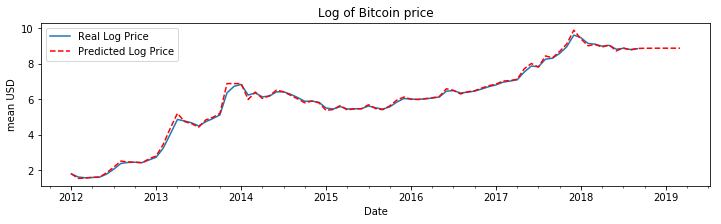

In [66]:
plt.figure(figsize=(12,3))
log_dfm['Log.Price'].plot(label='Real Log Price')
pred_log['Pred.Log.Price'].plot(color='r', ls='--', label='Predicted Log Price') # 'r+', ls='--'
plt.legend(loc='best')
plt.title('Log of Bitcoin price')
plt.ylabel('mean USD')
plt.show()

In [67]:
mse = mean_squared_error(log_dfm['Log.Price'], pred_log['Pred.Log.Price'].iloc[:-6])
mse

0.013424971498218405

In [33]:
print(df_month.index[:5])
print(best_model.fittedvalues.index[:5])

DatetimeIndex(['2012-01-31', '2012-02-29', '2012-03-31', '2012-04-30',
               '2012-05-31'],
              dtype='datetime64[ns]', name='Date', freq='M')
DatetimeIndex(['2012-01-31', '2012-02-29', '2012-03-31', '2012-04-30',
               '2012-05-31'],
              dtype='datetime64[ns]', name='Date', freq='M')


In [ ]:
# def invboxcox(y,lmbda):
#     if lmbda == 0:
#         return(np.exp(y))
#     else:
#         return(np.exp(np.log(lmbda*y+1)/lmbda))

In [34]:
pred_price = pred_log.copy()
pred_price.columns = ['Pred.Price']
pred_price['Pred.Price'] = np.exp(pred_price['Pred.Price'])
pred_price['Pred.Price'] = pred_price['Pred.Price']
pred_price.head()

,Pred.Price
Date,
2012-01-31,6.116452
2012-02-29,4.734104
2012-03-31,4.818285
2012-04-30,5.025090
2012-05-31,5.108404


In [35]:
df_month.head(2)

,Price
Date,
2012-01-31,6.116452
2012-02-29,5.106897


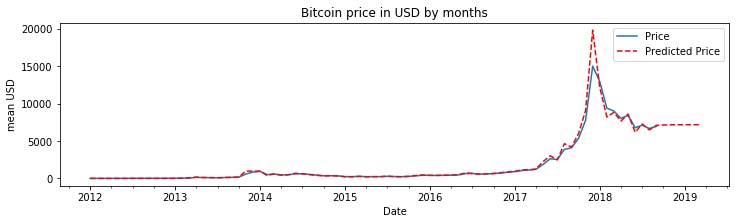

In [36]:
plt.figure(figsize=(12,3))
df_month['Price'].plot()
pred_price['Pred.Price'].plot(color='r', ls='--', label='Predicted Price') # 'r+'
plt.legend(loc='best')
plt.title('Bitcoin price in USD by months')
plt.ylabel('mean USD')
plt.show()

In [37]:
mse = mean_squared_error(df_month['Price'], pred_price['Pred.Price'].iloc[:-6])
mse

357990.1475478551

In [38]:
ret_log_dfm = log_dfm.diff().iloc[1:]
ret_log_dfm.columns = ['Ret.Log.Price']
print(ret_log_dfm.head(2))
pred_ret_log = pred_log.diff().iloc[1:]
pred_ret_log.columns = ['Pred.Ret.Log.Price']
print(pred_ret_log.head(2))

            Ret.Log.Price
Date                     
2012-02-29      -0.180390
2012-03-31      -0.040962
            Pred.Ret.Log.Price
Date                          
2012-02-29           -0.256190
2012-03-31            0.017626


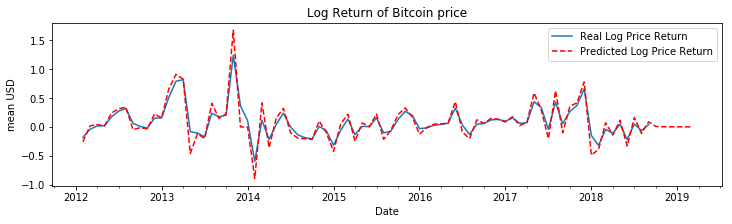

In [39]:
plt.figure(figsize=(12,3))
ret_log_dfm['Ret.Log.Price'].plot(label='Real Log Price Return')
pred_ret_log['Pred.Ret.Log.Price'].plot(color='r', ls='--', label='Predicted Log Price Return') # 'r+', ls='--'
plt.legend(loc='best')
plt.title('Log Return of Bitcoin price')
plt.ylabel('mean USD')
plt.show()

In [40]:
mse = mean_squared_error(pred_ret_log['Pred.Ret.Log.Price'].iloc[:-6], ret_log_dfm['Ret.Log.Price'])
mse

0.015679809467770086

In [41]:
sign_check = pd.merge(ret_log_dfm, pred_ret_log, how='left', left_index=True, right_index=True)
print(sign_check.head(2))
print(sign_check.tail(2))
sign_check.shape

            Ret.Log.Price  Pred.Ret.Log.Price
Date                                         
2012-02-29      -0.180390           -0.256190
2012-03-31      -0.040962            0.017626
            Ret.Log.Price  Pred.Ret.Log.Price
Date                                         
2018-08-31      -0.065541           -0.114281
2018-09-30       0.042837            0.088377


(80, 2)

In [42]:
sign_check['check'] = sign_check['Ret.Log.Price'] * sign_check['Pred.Ret.Log.Price']
sign_check.head(2)

,Ret.Log.Price,Pred.Ret.Log.Price,check
Date,,,
2012-02-29,-0.180390,-0.256190,0.046214
2012-03-31,-0.040962,0.017626,-0.000722


In [43]:
sign_check['check'] = sign_check['check'].apply(lambda x: 1 if x > 0 else 0)
sign_check.head(2)

,Ret.Log.Price,Pred.Ret.Log.Price,check
Date,,,
2012-02-29,-0.180390,-0.256190,1
2012-03-31,-0.040962,0.017626,0


In [44]:
np.sum(sign_check.check)/sign_check.shape[0], sign_check.shape[0]

(0.8875, 80)

In [45]:
print('real + and pred +:', sign_check[sign_check['Ret.Log.Price'] > 0][sign_check['Pred.Ret.Log.Price'] > 0].shape[0])
print('real + and pred -:', sign_check[sign_check['Ret.Log.Price'] > 0][sign_check['Pred.Ret.Log.Price'] < 0].shape[0])
print('real - and pred +:', sign_check[sign_check['Ret.Log.Price'] < 0][sign_check['Pred.Ret.Log.Price'] > 0].shape[0])
print('real - and pred -:', sign_check[sign_check['Ret.Log.Price'] < 0][sign_check['Pred.Ret.Log.Price'] < 0].shape[0])

real + and pred +: 46
real + and pred -: 6
real - and pred +: 3
real - and pred -: 25


## Iteration

In [46]:
log_dfm.tail(3)

,Log.Price
Date,
2018-07-31,8.871806
2018-08-31,8.806265
2018-09-30,8.849101


In [47]:
print(log_dfm.shape)
print(pred_log.shape)
pred_log.tail(10)

(81, 1)
(87, 1)


,Pred.Log.Price
Date,
2018-06-30,8.729278
2018-07-31,8.893006
2018-08-31,8.778724
2018-09-30,8.867101
2018-10-31,8.874664
2018-11-30,8.877843
2018-12-31,8.879178
2019-01-31,8.879739
2019-02-28,8.879975


In [50]:
forecast = best_model.forecast()
forecast

2018-10-31    8.867101
Freq: M, dtype: float64

In [127]:
model_it=sm.tsa.statespace.SARIMAX(log_dfm['Log.Price'], order=(1, 1, 0), seasonal_order=(0, 0, 0, 12)).fit()
pred_log_it = pd.DataFrame(model_it.predict(start=0, end=82))
pred_log_it.index.name = 'Date'
pred_log_it.columns = ['Pred.Log.Price.It']
pred_log_it['Pred.Log.Price.It'] = pred_log_it['Pred.Log.Price.It'].shift(-1)
pred_log_it = pred_log_it.iloc[:-1]
pred_log_it.head(2)

,Pred.Log.Price.It
Date,
2012-01-31,1.810982
2012-02-29,1.554792


In [128]:
pred_log_it.tail(2)

,Pred.Log.Price.It
Date,
2018-09-30,8.867101
2018-10-31,8.874664


In [129]:
for i in range(5):
    end_num = 83+i
    model_it=sm.tsa.statespace.SARIMAX(pred_log_it['Pred.Log.Price.It'], order=(1, 1, 0), seasonal_order=(0, 0, 0, 12)).fit()
    pred_log_it = pd.DataFrame(model_it.predict(start=0, end=end_num))
    pred_log_it.index.name = 'Date'
    pred_log_it.columns = ['Pred.Log.Price.It']
    pred_log_it['Pred.Log.Price.It'] = pred_log_it['Pred.Log.Price.It'].shift(-1)
    pred_log_it = pred_log_it.iloc[:-1]

In [130]:
print(pred_log_it.shape)
print(pred_log_it.head(3))
print(pred_log_it.tail(3))

(87, 1)
            Pred.Log.Price.It
Date                         
2012-01-31           1.810982
2012-02-29           1.519478
2012-03-31           1.575059
            Pred.Log.Price.It
Date                         
2019-01-31           8.875783
2019-02-28           8.875783
2019-03-31           8.875783


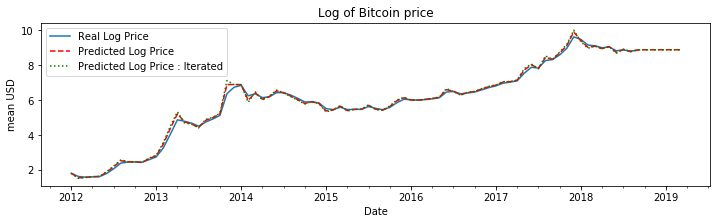

In [137]:
plt.figure(figsize=(12,3))
log_dfm['Log.Price'].plot(label='Real Log Price')
pred_log['Pred.Log.Price'].plot(color='r', ls='--', label='Predicted Log Price') # 'r+', ls='--'
pred_log_it['Pred.Log.Price.It'].plot(color='g', ls=':', label='Predicted Log Price : Iterated') # 'r+', ls='--'
plt.legend(loc='best')
plt.title('Log of Bitcoin price')
plt.ylabel('mean USD')
plt.show()

In [ ]:
pred_price = pred_log.copy()
pred_price.columns = ['Pred.Price']
pred_price['Pred.Price'] = np.exp(pred_price['Pred.Price'])
pred_price['Pred.Price'] = pred_price['Pred.Price']
pred_price.head()

In [ ]:
plt.figure(figsize=(12,3))
ret_log_dfm['Ret.Log.Price'].plot(label='Real Log Price Return')
pred_ret_log['Pred.Ret.Log.Price'].plot(color='r', ls='--', label='Predicted Log Price Return') # 'r+', ls='--'
plt.legend(loc='best')
plt.title('Log Return of Bitcoin price')
plt.ylabel('mean USD')
plt.show()

In [ ]:
ret_log_dfm = log_dfm.diff().iloc[1:]
ret_log_dfm.columns = ['Ret.Log.Price']
print(ret_log_dfm.head(2))
pred_ret_log = pred_log.diff().iloc[1:]
pred_ret_log.columns = ['Pred.Ret.Log.Price']
print(pred_ret_log.head(2))

In [ ]:
plt.figure(figsize=(12,3))
df_month['Price'].plot()
pred_price['Pred.Price'].plot(color='r', ls='--', label='Predicted Price') # 'r+'
plt.legend(loc='best')
plt.title('Bitcoin price in USD by months')
plt.ylabel('mean USD')
plt.show()